# Geometries in pyFAI

This notebook demonstrates the different orientations of axes in the geometry used by pyFAI.

## Demonstration
The tutorial uses the *Jupyter-Lab*. 


In [1]:
# %matplotlib widget
#For documentation purpose, `inline` is used to enforce the storage of images into the notebook
%matplotlib inline

import time
start_time = time.perf_counter()
from matplotlib.pyplot import subplots
import numpy

In [2]:
import pyFAI, pyFAI.detectors
print("Using pyFAI version", pyFAI.version)
from pyFAI.gui import jupyter
from pyFAI.calibrant import get_calibrant
from pyFAI.integrator.azimuthal import AzimuthalIntegrator

Using pyFAI version 2025.1.0-dev0


We will use a fake detector of 1000x1000 pixels of 100_µm each.
The simulated beam has a wavelength of 0.1_nm and the calibrant chose is silver behenate which gives regularly spaced rings.
The detector will originally be placed at 1_m from the sample.

In [3]:
wl = 1e-10
cal = get_calibrant("AgBh")
cal.wavelength=wl

detector = pyFAI.detectors.Detector(100e-6, 100e-6)
detector.max_shape=(1000,1000)

ai = AzimuthalIntegrator(dist=1, detector=detector, wavelength=wl)

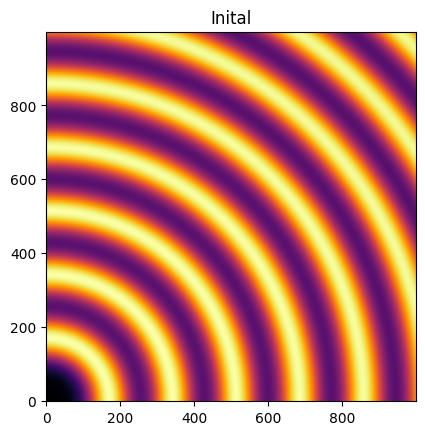

In [4]:
img = cal.fake_calibration_image(ai)
jupyter.display(img, label="Inital")
pass

## Translation orthogonal to the beam: poni1 and poni2
We will now set the first dimension (vertical) offset to the center of the detector: 100e-6 * 1000 / 2

poni1: 0.05


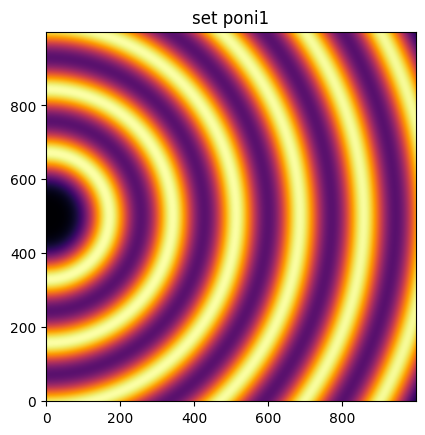

In [5]:
p1 = 100e-6 * 1000 / 2
print("poni1:", p1)
ai.poni1 = p1
img = cal.fake_calibration_image(ai)
jupyter.display(img, label="set poni1")
pass

Let's do the same in the second dimensions: along the horizontal axis

poni2: 0.05
Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 5.000000e-02, 5.000000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1000.000 mm	Center: x=500.000, y=500.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å


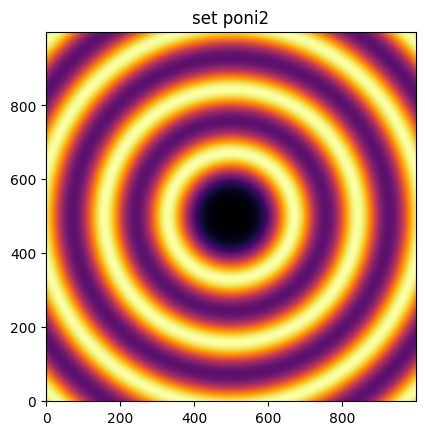

In [6]:
p2 = 100e-6 * 1000 / 2
print("poni2:", p2)
ai.poni2 = p2
print(ai)
img = cal.fake_calibration_image(ai)
jupyter.display(img, label="set poni2")
pass

The image is now properly centered. Let's investigate the sample-detector distance dimension.

For this we need to describe a detector which has a third dimension which will be offseted in the third dimension by half a meter.




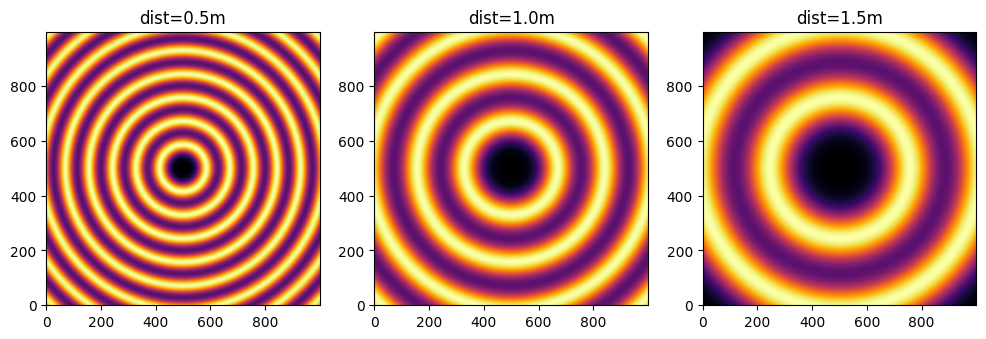

In [7]:
#define 3 plots
fig, ax = subplots(1, 3, figsize=(12,4))

import copy 
ref_10 = cal.fake_calibration_image(ai, W=1e-4)
jupyter.display(ref_10, label="dist=1.0m", ax=ax[1])

ai05 = copy.copy(ai)
ai05.dist = 0.5
ref_05 = cal.fake_calibration_image(ai05, W=1e-4)
jupyter.display(ref_05, label="dist=0.5m", ax=ax[0])

ai15 = copy.copy(ai)
ai15.dist = 1.5
ref_15 = cal.fake_calibration_image(ai15, W=1e-4)
jupyter.display(ref_15, label="dist=1.5m", ax=ax[2])
pass

We test now if the sensot of the detector is not located at Z=0 in the detector referential but any arbitrary value:

In [8]:

class ShiftedDetector(pyFAI.detectors.Detector):
    IS_FLAT = False  # this detector is flat
    IS_CONTIGUOUS = True  # No gaps: all pixels are adjacents, speeds-up calculation
    API_VERSION = "1.0"
    aliases = ["ShiftedDetector"]
    MAX_SHAPE=1000,1000
    def __init__(self, pixel1=100e-6, pixel2=100e-6, offset=0):
        pyFAI.detectors.Detector.__init__(self, pixel1=pixel1, pixel2=pixel2)
        self.d3_offset = offset
    def calc_cartesian_positions(self, d1=None, d2=None, center=True, use_cython=True):
        res = pyFAI.detectors.Detector.calc_cartesian_positions(self, d1=d1, d2=d2, center=center, use_cython=use_cython)
        return res[0], res[1], numpy.ones_like(res[1])*self.d3_offset

#This creates a detector offseted by half a meter !
shiftdet = ShiftedDetector(offset=0.5)
print(shiftdet)


Detector ShiftedDetector	 PixelSize= 100µm, 100µm	 BottomRight (3)


Detector ShiftedDetector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 5.000000e-02, 5.000000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1000.000 mm	Center: x=500.000, y=500.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å


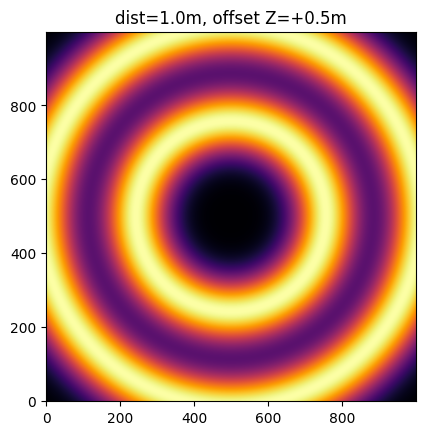

In [9]:
aish = AzimuthalIntegrator(dist=1, poni1=p1, poni2=p2, detector=shiftdet, wavelength=wl)
print(aish)
shifted = cal.fake_calibration_image(aish, W=1e-4)
jupyter.display(shifted, label="dist=1.0m, offset Z=+0.5m")
pass

This image is the same as the one with dist=1.5m
The positive distance along the *d3* direction is equivalent to increase the distance. 
*d3* is in the same direction as the incoming beam.

After investigation of the three translations, we will now investigate the rotation along the different axes.

## Investigation on the rotations:

Any rotations of the detector apply after the 3 translations (*dist*, *poni1* and *poni2*)

The first axis is the vertical one and a rotation around it ellongates ellipses along the orthogonal axis:

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 5.000000e-02, 5.000000e-02 m	rot1=0.200000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1020.339 mm	Center: x=-1527.100, y=500.000 pix	Tilt= 11.459° tiltPlanRotation= 180.000° 𝛌= 1.000Å


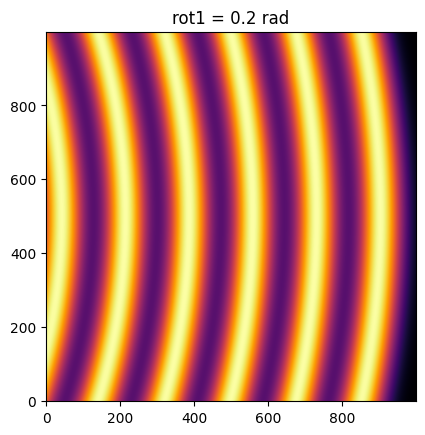

In [10]:
rotation = +0.2
ai.rot1 = rotation
print(ai)
img = cal.fake_calibration_image(ai)
jupyter.display(img, label="rot1 = 0.2 rad")
pass

So a positive rot1 is equivalent to turning the detector to the right, around the sample position (where the observer is).

Let's consider now the rotation along the horizontal axis, rot2:

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 5.000000e-02, 5.000000e-02 m	rot1=0.000000  rot2=0.200000  rot3=0.000000 rad
DirectBeamDist= 1020.339 mm	Center: x=500.000, y=2527.100 pix	Tilt= 11.459° tiltPlanRotation= 90.000° 𝛌= 1.000Å


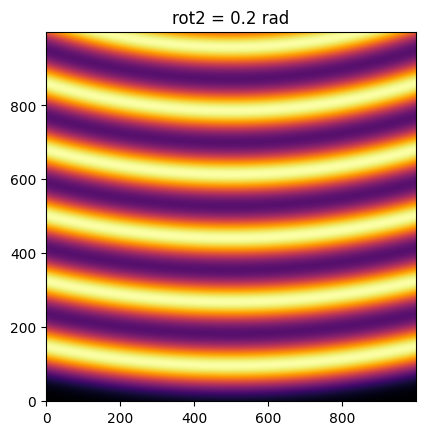

In [11]:
rotation = +0.2
ai.rot1 = 0
ai.rot2 = rotation
print(ai)
img = cal.fake_calibration_image(ai)

jupyter.display(img, label="rot2 = 0.2 rad")
pass

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 5.000000e-02, 5.000000e-02 m	rot1=0.200000  rot2=0.200000  rot3=0.000000 rad
DirectBeamDist= 1041.091 mm	Center: x=-1527.100, y=2568.329 pix	Tilt= 16.151° tiltPlanRotation= 134.423° 𝛌= 1.000Å


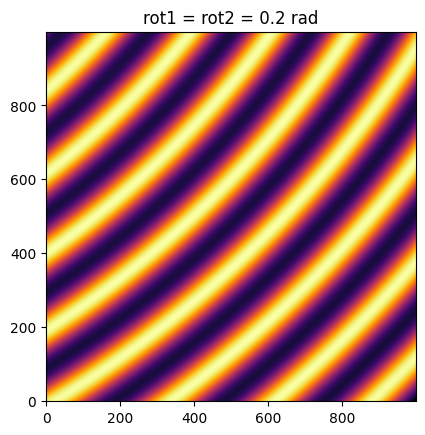

In [12]:
rotation = +0.2
ai.rot1 = rotation
ai.rot2 = rotation
ai.rot3 = 0
print(ai)
img = cal.fake_calibration_image(ai)

jupyter.display(img, label="rot1 = rot2 = 0.2 rad")
pass

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 5.000000e-02, 5.000000e-02 m	rot1=0.200000  rot2=0.200000  rot3=0.200000 rad
DirectBeamDist= 1041.091 mm	Center: x=-1527.100, y=2568.329 pix	Tilt= 16.151° tiltPlanRotation= 134.423° 𝛌= 1.000Å


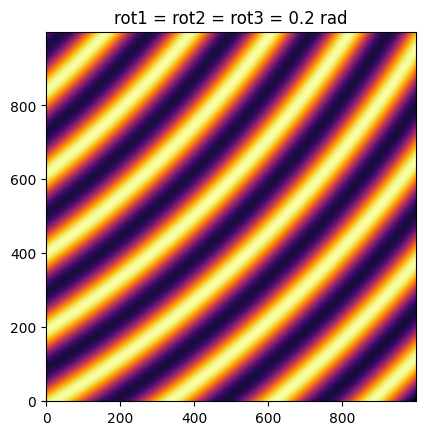

In [13]:
rotation = +0.2
import copy
ai2 = copy.copy(ai)
ai2.rot1 = rotation
ai2.rot2 = rotation
ai2.rot3 = rotation
print(ai2)
img2 = cal.fake_calibration_image(ai2)


jupyter.display(img2, label="rot1 = rot2 = rot3 = 0.2 rad")
pass

If one considers the rotation along the incident beam, there is no visible effect on the image as the image is invariant along this transformation.

To actually see the effect of this third rotation one needs to perform the azimuthal integration and display the result with properly labeled axes.

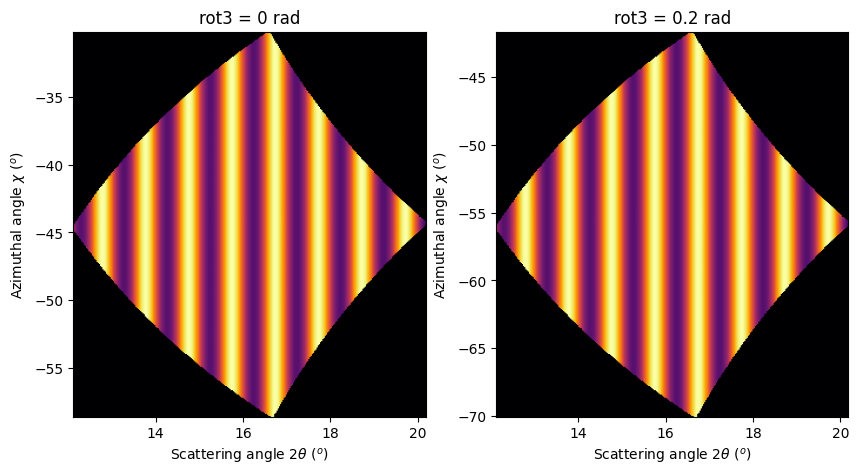

In [14]:
fig, ax = subplots(1,2,figsize=(10,5))

res1 = ai.integrate2d_ng(img, 300, 360, unit="2th_deg")
jupyter.plot2d(res1, label="rot3 = 0 rad", ax=ax[0])

res2 = ai2.integrate2d_ng(img2, 300, 360, unit="2th_deg")
jupyter.plot2d(res2, label="rot3 = 0.2 rad", ax=ax[1])
pass

So the increasing *rot3* creates more negative azimuthal angles: it is like rotating the detector clockwise around the incident beam.

## Conclusion

All 3 translations and all 3 rotations can be summarized in the following figure: 

![PONI figure](../../../img/PONI.png "test")


**Nota:**: While the system (x_1, x_2, x_3) is direct, the rotation number 1 and 2 are indirect and rot3 is direct again. This is technical debt.

In [15]:
print(f"Processing time: {time.perf_counter()-start_time:.3f}s")

Processing time: 5.319s
